<a href="https://colab.research.google.com/github/yedini/DL_tensorflow/blob/main/Part3_Lab02_Mnist_CNN_Keras_Sequential_eager.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

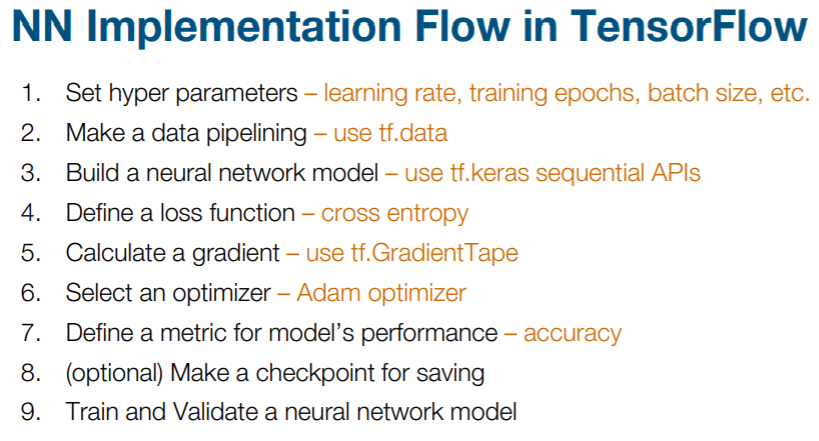         
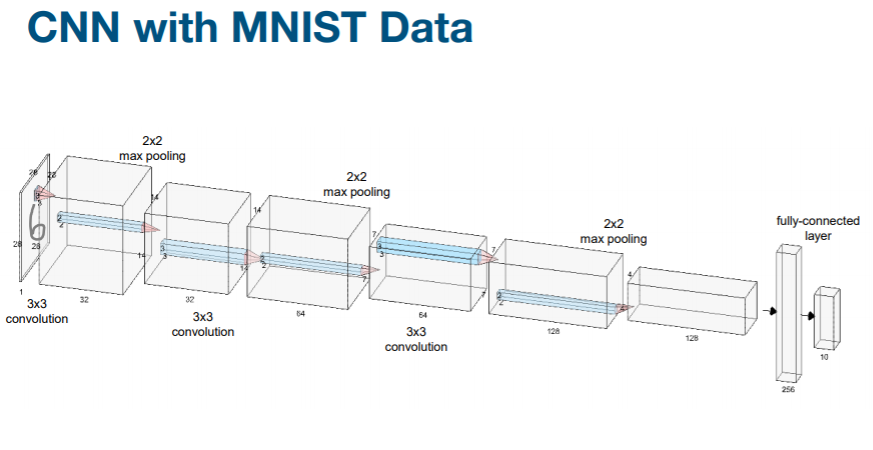

- convolution은 모두 3x3, stride=1, padding='SAME',
- maxpooling: stride=2, padding='SAME'
- convolution filter size는 2배씩 늘려가고, 가로 세로 size는 pooling에 의해 절반씩 줄어듦.

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import os

print(tf.__version__)
print(keras.__version__)

2.5.0
2.5.0


In [ ]:
# hyper parameter
learning_rate = 0.001
training_epochs = 15
batch_size = 100

tf.random.set_seed(777)

In [ ]:
# creating a checkpoint directory
cur_dir = os.getcwd()
ckpt_dir_name = 'checkpoints'
model_dir_name = 'minst_cnn_seq'

checkpoint_dir = os.path.join(cur_dir, ckpt_dir_name, model_dir_name)
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, model_dir_name)

In [ ]:
# Data Pipelining
mnist = keras.datasets.mnist
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()    
# (60000,28,28), (60000,)      (10000,28,28)  (10000,)    => channel이 빠져있음.  
train_images = train_images.astype(np.float32) / 255.
test_images = test_images.astype(np.float32) / 255.
train_images = np.expand_dims(train_images, axis=-1)  #마지막 차원 하나 추가하기
test_images = np.expand_dims(test_images, axis=-1)
    
train_labels = to_categorical(train_labels, 10)  #one-hot encoding
test_labels = to_categorical(test_labels, 10)    
    
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(
                buffer_size=100000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size) #test에서는 shuffle 안씀

11493376/11490434 [==============================] - 0s 0us/step


#### Sequential API

In [ ]:
# Model Function
def create_model():
    model = keras.Sequential()   #sequential API를 쓸 것을 선언함. => 쌓는 순서대로 layer들이 쌓이는 구조.
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation=tf.nn.relu, padding='SAME', 
                                  input_shape=(28, 28, 1)))  #첫번째 layer에는 input shape을 적어주는게 좋다
    model.add(keras.layers.MaxPool2D(padding='SAME'))  # 2x2 에 stride=2인 filter가 default로 사용됨.
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation=tf.nn.relu, padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation=tf.nn.relu, padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))

    #fully connected
    model.add(keras.layers.Flatten()) #위에까지의 feature map을 vector로 쭉 펴줌.
    model.add(keras.layers.Dense(256, activation=tf.nn.relu))
    model.add(keras.layers.Dropout(0.4))  #parameter 개수가 많아서 dropout을 추가해준다.
    model.add(keras.layers.Dense(10))  #최종으로 구부해야할 label 개수
    return model

In [ ]:
model = create_model()
model.summary()  #모델 정보

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

In [ ]:
# loss function
def loss_fn(model, images, labels):
    logits = model(images, training=True)
    loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(
        y_pred=logits, y_true=labels, from_logits=True))    
    return loss

In [ ]:
# Calculating Gradient
def grad(model, images, labels):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, images, labels)
    return tape.gradient(loss, model.variables) #backpropagation으로 기울기 계산

In [ ]:
# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [ ]:
# Calculating Accuracy
def evaluate(model, images, labels):
    logits = model(images, training=False)
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

In [ ]:
# creating a checkpoint
checkpoint = tf.train.Checkpoint(cnn=model)

In [ ]:
# training
def train(model, images, labels):
    grads = grad(model, images, labels)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
# train model
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_loss = 0.
    avg_train_acc = 0.
    avg_test_acc = 0.
    train_step = 0
    test_step = 0    
    
    for images, labels in train_dataset:
        train(model, images, labels)
        #grads = grad(model, images, labels)                
        #optimizer.apply_gradients(zip(grads, model.variables))

        #error 계산(optional)
        loss = loss_fn(model, images, labels)
        acc = evaluate(model, images, labels)
        avg_loss = avg_loss + loss
        avg_train_acc = avg_train_acc + acc
        train_step += 1
    avg_loss = avg_loss / train_step
    avg_train_acc = avg_train_acc / train_step
    
    for images, labels in test_dataset:        
        acc = evaluate(model, images, labels)        
        avg_test_acc = avg_test_acc + acc
        test_step += 1    
    avg_test_acc = avg_test_acc / test_step    

    print('Epoch:', '{}'.format(epoch + 1), 'loss =', '{:.8f}'.format(avg_loss), 
          'train accuracy = ', '{:.4f}'.format(avg_train_acc), 
          'test accuracy = ', '{:.4f}'.format(avg_test_acc))
    
    checkpoint.save(file_prefix=checkpoint_prefix)

print('Learning Finished!')

Learning started. It takes sometime.
Epoch: 1 loss = 0.17267708 train accuracy =  0.9588 test accuracy =  0.9852
Epoch: 2 loss = 0.04380592 train accuracy =  0.9906 test accuracy =  0.9912
Epoch: 3 loss = 0.03147789 train accuracy =  0.9934 test accuracy =  0.9918
Epoch: 4 loss = 0.02174140 train accuracy =  0.9958 test accuracy =  0.9916
Epoch: 5 loss = 0.01772320 train accuracy =  0.9968 test accuracy =  0.9932
Epoch: 6 loss = 0.01547519 train accuracy =  0.9972 test accuracy =  0.9916
Epoch: 7 loss = 0.01154508 train accuracy =  0.9979 test accuracy =  0.9925
Epoch: 8 loss = 0.01112204 train accuracy =  0.9985 test accuracy =  0.9937
Epoch: 9 loss = 0.00876119 train accuracy =  0.9989 test accuracy =  0.9901
Epoch: 10 loss = 0.00788917 train accuracy =  0.9988 test accuracy =  0.9929
Epoch: 11 loss = 0.00632686 train accuracy =  0.9992 test accuracy =  0.9934
Epoch: 12 loss = 0.00582461 train accuracy =  0.9992 test accuracy =  0.9941
Epoch: 13 loss = 0.00560204 train accuracy =  0.

### tf keras Functional API 사용     
Sequential API의 경우, multi input/output 모델, models with shared layers, models with non-sequential data flow를 만들 수 없음.

In [ ]:
def create_model():
    inputs = keras.Input(shape=(28, 28, 1))  #input layer 선언!
    #sequential API와 다르게 모든 layer에서 어떤 input이 들어가는지를 명시함
    conv1 = keras.layers.Conv2D(filters=32, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)(inputs)
    pool1 = keras.layers.MaxPool2D(padding='SAME')(conv1)
    conv2 = keras.layers.Conv2D(filters=64, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)(pool1)
    pool2 = keras.layers.MaxPool2D(padding='SAME')(conv2)
    conv3 = keras.layers.Conv2D(filters=128, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)(pool2)
    pool3 = keras.layers.MaxPool2D(padding='SAME')(conv3)
    pool3_flat = keras.layers.Flatten()(pool3)
    dense4 = keras.layers.Dense(units=256, activation=tf.nn.relu)(pool3_flat)
    drop4 = keras.layers.Dropout(rate=0.4)(dense4)
    logits = keras.layers.Dense(units=10)(drop4)
    return keras.Model(inputs=inputs, outputs=logits)

In [ ]:
model = create_model()
model.summary()

### tf.keras.Model Subclassing      
fully-customizable model을 만들 수 있음.    
class를 만들고 __init__에 layer를 쌓고 call에서 input과 연결함.

In [ ]:
class MNISTModel(tf.keras.Model):
    def __init__(self):
        super(MNISTModel, self).__init__()  # 이 안에서 sequential / functional API 둘다 사용 가능
        self.conv1 = keras.layers.Conv2D(filters=32, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)
        self.pool1 = keras.layers.MaxPool2D(padding='SAME')
        self.conv2 = keras.layers.Conv2D(filters=64, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)
        self.pool2 = keras.layers.MaxPool2D(padding='SAME')
        self.conv3 = keras.layers.Conv2D(filters=128, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)
        self.pool3 = keras.layers.MaxPool2D(padding='SAME')
        self.pool3_flat = keras.layers.Flatten()
        self.dense4 = keras.layers.Dense(units=256, activation=tf.nn.relu)
        self.drop4 = keras.layers.Dropout(rate=0.4)
        self.dense5 = keras.layers.Dense(units=10)
    def call(self, inputs, training=False):   # input 설정
        net = self.conv1(inputs)
        net = self.pool1(net)
        net = self.conv2(net)
        net = self.pool2(net)
        net = self.conv3(net)
        net = self.pool3(net)
        net = self.pool3_flat(net)
        net = self.dense4(net)
        net = self.drop4(net)
        net = self.dense5(net)
        return net

In [ ]:
model = MNISTModel()
temp_inputs = keras.Input(shape=(28, 28, 1))
model(temp_inputs)
model.summary()